<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Разбивка-на-выборки" data-toc-modified-id="Разбивка-на-выборки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разбивка на выборки</a></span></li></ul></li><li><span><a href="#Обучение-линейной-регрессии" data-toc-modified-id="Обучение-линейной-регрессии-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение линейной регрессии</a></span></li><li><span><a href="#Другие-модели" data-toc-modified-id="Другие-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Другие модели</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План работ:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Анализ данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
#сразу сделаем столблец с датами индексом
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
#сортируем индексы/даты на случай если где-то они идут не по порядку
data.sort_index(inplace=True)
display(data.head(5))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Подготовка

In [4]:
#ресемплирование по 1 часу
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [5]:
#функция для подготовки признаков
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [6]:
make_features(data, 5, 5)

data.head(5)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN


### Разбивка на выборки

In [7]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train_valid = train_valid.dropna()

features_train_valid = train_valid.drop(['num_orders'], axis=1)
target_train_valid = train_valid['num_orders']

train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

#проверка корректности разбивки
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-01 05:00:00 2018-07-28 00:00:00
2018-07-28 01:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


## Обучение линейной регрессии

In [8]:
model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression()

In [9]:
predictions_lr = model.predict(features_valid)
rmse_lr = mean_squared_error(target_valid, predictions_lr) ** .5

print('RMSE:', rmse_lr)

RMSE: 40.66452939346451


In [10]:
print('Реальное кол-во заказов на следующий час:', target_valid[0])
print('Предсказанное кол-во заказов:', predictions_lr[0])

Реальное кол-во заказов на следующий час: 195
Предсказанное кол-во заказов: 131.44797384375693


## Другие модели

In [11]:
#дерево решений

best_rmse_tree = 1000
best_depth=0

for depth in range(1, 11):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_tree = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predictions_tree) ** .5
    
    if rmse < best_rmse_tree:
        best_rmse_tree = rmse
        best_depth = depth

print('best_depth:', best_depth)
print('RMSE:', best_rmse_tree)
print()
print('Реальное кол-во заказов на следующий час:', target_valid[0])
print('Предсказанное кол-во заказов:', predictions_tree[0])

best_depth: 6
RMSE: 35.457057915028784

Реальное кол-во заказов на следующий час: 195
Предсказанное кол-во заказов: 133.5


In [12]:
#CatBoost
best_rmse_cat = 1000
best_iter = 0
best_model = None

for iteration in range(10, 200, 10):
    model = CatBoostRegressor(random_state=12345, iterations=iteration)
    model.fit(features_train, target_train)
    predictions_cat = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predictions_cat) ** .5
    
    if rmse < best_rmse_cat:
        best_rmse_cat = rmse
        best_iter = iteration
        best_model = model

print('best_iterations:', best_iter)
print('RMSE:', best_rmse_cat)
print()
print('Реальное кол-во заказов на следующий час:', target_valid[0])
print('Предсказанное кол-во заказов:', best_model.predict(features_test)[0])

Learning rate set to 0.5
0:	learn: 30.0298250	total: 48.3ms	remaining: 435ms
1:	learn: 26.0185891	total: 50.1ms	remaining: 201ms
2:	learn: 24.1637863	total: 51.8ms	remaining: 121ms
3:	learn: 23.4684873	total: 53.4ms	remaining: 80.1ms
4:	learn: 22.9214900	total: 55.1ms	remaining: 55.1ms
5:	learn: 22.5844153	total: 56.7ms	remaining: 37.8ms
6:	learn: 22.1623220	total: 58.3ms	remaining: 25ms
7:	learn: 21.5765841	total: 59.9ms	remaining: 15ms
8:	learn: 21.3734849	total: 61.5ms	remaining: 6.83ms
9:	learn: 20.9919722	total: 63.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 30.0298250	total: 1.95ms	remaining: 37ms
1:	learn: 26.0185891	total: 3.73ms	remaining: 33.5ms
2:	learn: 24.1637863	total: 5.46ms	remaining: 30.9ms
3:	learn: 23.4684873	total: 7.15ms	remaining: 28.6ms
4:	learn: 22.9214900	total: 8.83ms	remaining: 26.5ms
5:	learn: 22.5844153	total: 10.4ms	remaining: 24.4ms
6:	learn: 22.1623220	total: 12ms	remaining: 22.3ms
7:	learn: 21.5765841	total: 13.6ms	remaining: 20.5ms
8:	learn: 

In [13]:
#сравнение моделей
comparison = pd.DataFrame({'model': ['LinearRegression', 'DecisionTree', 'CatBoost'], 
                    'RMSE': [rmse_lr, best_rmse_tree, best_rmse_cat],
                    'Next hour prediction': [131.4, 133.5, 83.9]})

display(comparison)
print('Реальное кол-во заказов на следующий час:', target_valid[0])

,model,RMSE,Next hour prediction
0,LinearRegression,40.664529,133.3
1,DecisionTree,35.457058,133.5
2,CatBoost,32.824213,83.9


Реальное кол-во заказов на следующий час: 195


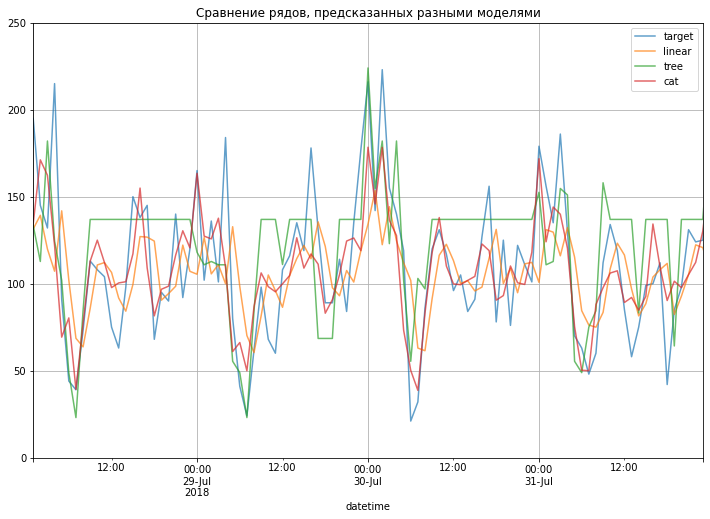

In [35]:
plot_data = pd.DataFrame()

plot_data['target'] = target_valid
plot_data['linear'] = predictions_lr
plot_data['tree'] = predictions_tree
plot_data['cat'] = predictions_cat

plot_data.plot(figsize=(12,8), 
               xlim=('2018-07-28 01:00:00', '2018-07-31 23:00:00'), 
               ylim=(0, 250), 
               title='Сравнение рядов, предсказанных разными моделями',
               grid=True,
               alpha=.7);

На графике видно, что деревянная модель с задачей справляется хуже других - график более угловат и примитивен, модель неспособна предсказывать значения ряда на небольшом временном шаге.

## Тестирование лучшей модели

In [36]:
model = CatBoostRegressor(random_state=12345, iterations=160)
model.fit(features_train_valid, target_train_valid)
predictions_cat_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions) ** .5

print(print('RMSE:', rmse))
print('Реальное кол-во заказов на следующий час:', target_test[0])
print('Предсказанное кол-во заказов:', predictions[0])

Learning rate set to 0.225851
0:	learn: 34.8006213	total: 2.62ms	remaining: 417ms
1:	learn: 31.8315300	total: 4.61ms	remaining: 364ms
2:	learn: 29.7432286	total: 6.52ms	remaining: 341ms
3:	learn: 28.3914036	total: 8.5ms	remaining: 331ms
4:	learn: 27.3363554	total: 10.4ms	remaining: 323ms
5:	learn: 26.5909181	total: 12.2ms	remaining: 314ms
6:	learn: 25.9047738	total: 14ms	remaining: 307ms
7:	learn: 25.4559419	total: 15.8ms	remaining: 300ms
8:	learn: 24.9111378	total: 17.7ms	remaining: 296ms
9:	learn: 24.6157220	total: 19.4ms	remaining: 291ms
10:	learn: 24.4411474	total: 21.2ms	remaining: 287ms
11:	learn: 24.1863555	total: 23ms	remaining: 284ms
12:	learn: 24.1078342	total: 24.8ms	remaining: 281ms
13:	learn: 23.7262283	total: 26.6ms	remaining: 277ms
14:	learn: 23.6748470	total: 28.4ms	remaining: 274ms
15:	learn: 23.5174455	total: 30.1ms	remaining: 271ms
16:	learn: 23.3572780	total: 31.9ms	remaining: 268ms
17:	learn: 23.1923337	total: 33.7ms	remaining: 266ms
18:	learn: 23.1606468	total: 35

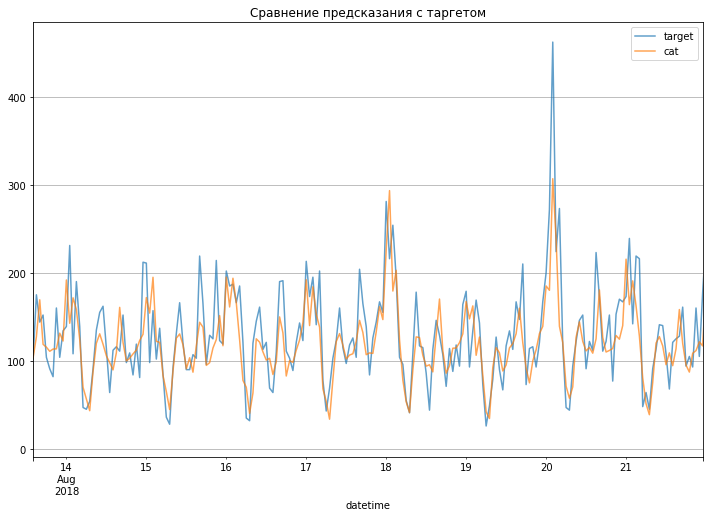

In [40]:
plot_test = pd.DataFrame()

plot_test['target'] = target_test
plot_test['cat'] = predictions_cat_test

plot_test.plot(figsize=(12,8), 
               xlim=('2018-08-13 14:00:00', '2018-08-21 23:00:00'), 
               title='Сравнение предсказания с таргетом',
               grid=True,
               alpha=.7);

## Вывод

На основании истории заказов за предыдущие 6 месяцев удалось построить модель, которая довольно точно прогнозирует количество заказов в следующий час и даже на несколько дней вперед. Для задачи требовалось создать модель, которая выдает RMSE меньше 48. На валидационной выборке все 3 опробованные модели справились с задачей, наилучшую метрику показала модель CatBoost. На тестовой выборке модель демонстриурет RMSE = 42.7, и очень близко попала в значение следующего часа - предсказанное число 103.2, реальное количество 102.

На графике сравнения предсказаний модели с таргетом видно, что модель довольно точно усвоила закономерности и тренды, благодаря чему отлично предсказывает количество заказов на тестовой выборке.

Для дальнейшей работы по предсказанию спроса на такси рекомендую модель CatBoost с iterations=160.